# **Introduction to Deep Learning for Visual Computing (INF01050 and CMP620)**
# **Assignment 1**
<!-- # Name(s): <font color='red'>Ulileh</font><font color='red'>Mariana Risco</font> -->
### 👩‍💻 Name(s): <span style="color:crimson; font-weight:bold;">Ulilé Indeque and Mariana Risco</span>


In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
import os

2025-05-04 19:19:22.038467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746386362.273671      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746386362.340379      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#
#  Common header for all students: download and unzip the dataset
#
# !wget https://www.inf.ufrgs.br/~crjung/fdl/modified_voc.zip
# !unzip modified_voc
# !ls -l

## 2. Split Dataset Train and Test
Based on the structure of the provided csv file, organize the data (images and labels) for
training and testing the models

In [35]:
print(ann["split"].value_counts())


split
train    867
test     335
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

ann = pd.read_csv("modified_voc/annotations.csv")
print(ann.shape)
display(ann.head())

train_path = ann[ann["split"] == "train"]
test_path  = ann[ann["split"] == "test"]


(1202, 4)


,image,dog,person,split
0,image_0062.jpg,0,0,train
1,image_0238.jpg,0,0,test
2,image_0674.jpg,0,1,train
3,image_0747.jpg,0,1,test
4,image_0252.jpg,0,0,train


In [ ]:
def read_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    return img, label

def map_imgs(df, base_path="modified_voc"):
    paths = df["image"].apply(lambda x: os.path.join(base_path, x)).values
    labels = df[["dog", "person"]].values.astype(np.float32)

    imgset = tf.data.Dataset.from_tensor_slices((paths, labels))
    imgset = imgset.map(
        read_img,
        num_parallel_calls=tf.data.AUTOTUNE).batch(128).prefetch(tf.data.AUTOTUNE)
    return imgset

img_train = map_imgs(train_path)
img_test = map_imgs(test_path)

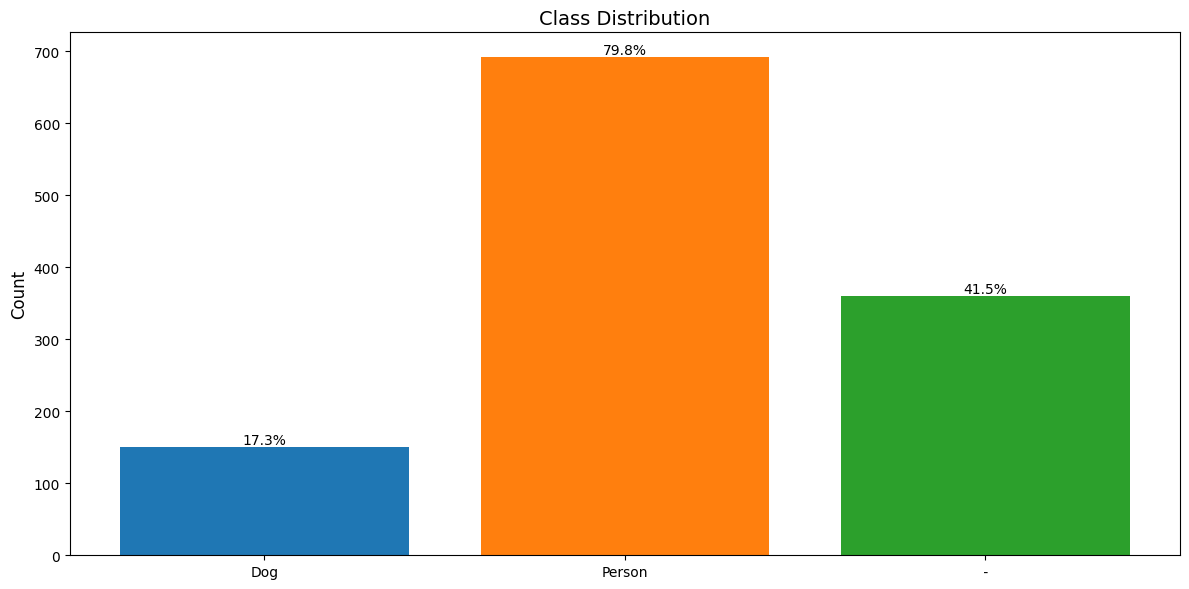

In [67]:
counts = ann[['dog', 'person']].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
bars = plt.bar(
    ['Dog', 'Person', ' - '],
    [counts['dog'], counts['person'], len(ann) - counts.sum()],
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)
plt.title('Class Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)

total = len(train_path)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height/total:.1%}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

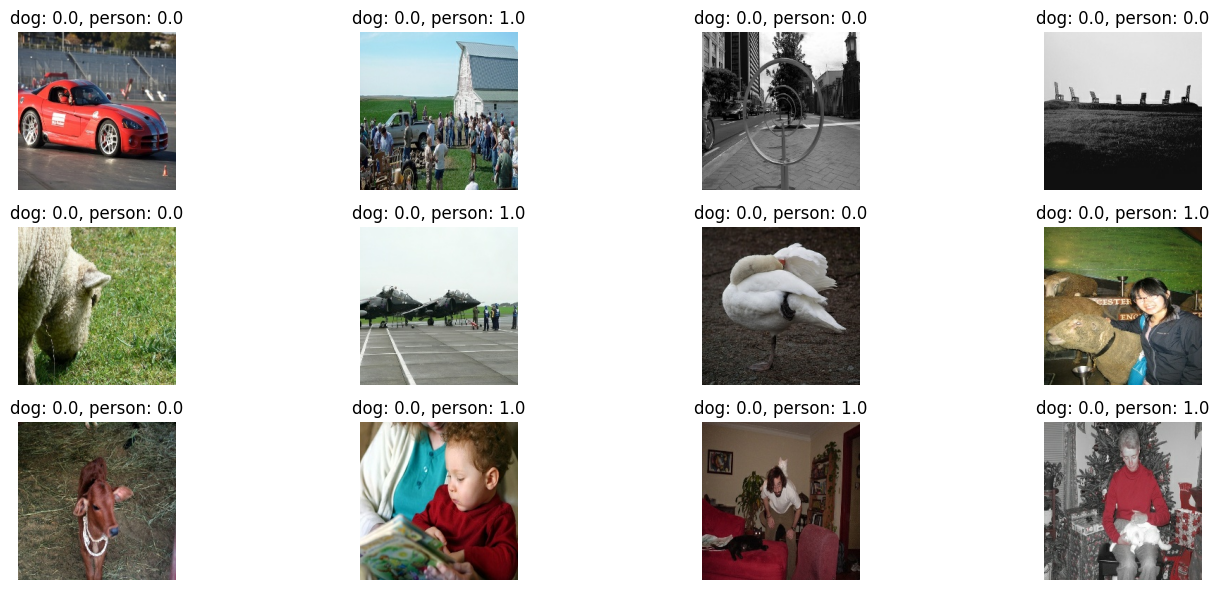

In [68]:
def print_imgs(batched):
    class_names = ["dog", "person"]
    plt.figure(figsize=(15, 6))
    for img, labels in batched.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(img[i].numpy().astype("uint8"))
            label_array = labels[i].numpy()
            label_str = ", ".join([f"{class_names[j]}: {val:.1f}" for j, val in enumerate(label_array)])
            plt.title(label_str)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

print_imgs(img_train)

In [124]:
def build_model():
    base_model = keras.applications.MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        name="base_model"
    )
    base_model.trainable = False

    # inputs = keras.Input(shape=(224, 224, 3))
    # x = keras.applications.mobilenet.preprocess_input(inputs)
    # x = base_model(x)
    # x = keras.layers.GlobalAveragePooling2D()(x)
    # x = keras.layers.Dense(128, activation='relu')(x)
    # x = keras.layers.Dropout(0.5)(x)
    # outputs = keras.layers.Dense(2, activation='sigmoid', name="output")(x)


    inputs = keras.Input(shape=(224, 224, 3))
    x = keras.applications.mobilenet.preprocess_input(inputs)
    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.BatchNormalization()(x)

    X = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(2, activation='sigmoid', name="output")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

    return model
model = build_model()
model.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_117 (InputLayer)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_58 (TrueDivide)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_58 (Subtract)               │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ base_model (Functional)              │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_59          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_152              │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_158 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_153              │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_159 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_154              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_160 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,892,674 (14.85 MB)

 Trainable params: 660,226 (2.52 MB)

 Non-trainable params: 3,232,448 (12.33 MB)

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow import keras

num_folds = 3 
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

train_accuracies = []
train_precisions = []
train_recalls = []
train_losses = []

accuracies = []
precisions = []
recalls = []
losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_path)):
    print(f"Entrenando para el fold {fold + 1}/{num_folds}...")
    
    train_fold = ann.iloc[train_idx]
    val_fold = ann.iloc[val_idx]
    
    img_train = map_imgs(train_fold)
    img_valid = map_imgs(val_fold)
    
    #model
    model = build_model()  
    
    # Callbacks
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'models/multilabels_model_fold{fold + 1}.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # early_stopping = tf.keras.callbacks.EarlyStopping(
    #     monitor='val_accuracy',
    #     patience=10,
    #     restore_best_weights=True,
    #     verbose=1
    # )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
    
    # Train
    history = model.fit(
        img_train,
        epochs=50,
        validation_data=img_valid,
        callbacks=[checkpoint, reduce_lr]
    )

   # metrics
    print(f"Fold {fold + 1} metrics: {history.history.keys()}")  

    train_accuracies.append(history.history['accuracy'])
    train_precisions.append(history.history['precision'])
    train_recalls.append(history.history['recall'])
    train_losses.append(history.history['loss'])
    
    # save metrics by fold
    accuracies.append(history.history['val_accuracy'])
    precisions.append(history.history['val_precision'])
    recalls.append(history.history['val_recall'])
    losses.append(history.history['val_loss'])


Entrenando para el fold 1/3...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.4865 - loss: 1.0275 - precision: 0.3088 - recall: 0.4568
Epoch 1: val_accuracy improved from -inf to 0.53979, saving model to multilabels_model_fold1.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4893 - loss: 1.0227 - precision: 0.3120 - recall: 0.4613 - val_accuracy: 0.5398 - val_loss: 0.9148 - val_precision: 0.3773 - val_recall: 0.9621 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5334 - loss: 0.9214 - precision: 0.3680 - recall: 0.5111 
Epoch 2: val_accuracy improved from 0.53979 to 0.61246, saving model to multilabels_model_fold1.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.5316 - loss: 0.9228 - precision: 0.3659 - recall: 0.5094 - val_accuracy: 0.6125 - val_loss: 0.8674 - val_precision: 0.3835 - val_recall: 0.9668 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5732 - loss: 0.

In [128]:
avg_train_accuracies = np.mean(train_accuracies, axis=0)
avg_train_precisions = np.mean(train_precisions, axis=0)
avg_train_recalls = np.mean(train_recalls, axis=0)
avg_train_losses = np.mean(train_losses, axis=0)

avg_accuracy = np.mean(accuracies, axis=0)
avg_precision = np.mean(precisions, axis=0)
avg_recall = np.mean(recalls, axis=0)
avg_loss = np.mean(losses, axis=0)

avg_metrics = {
    'accuracy': avg_train_accuracies,
    'precision': avg_train_precisions,
    'recall': avg_train_recalls,
    'loss': avg_train_losses,
    'val_accuracy': avg_accuracy,
    'val_precision': avg_precision,
    'val_recall': avg_recall,
    'val_loss': avg_loss
}


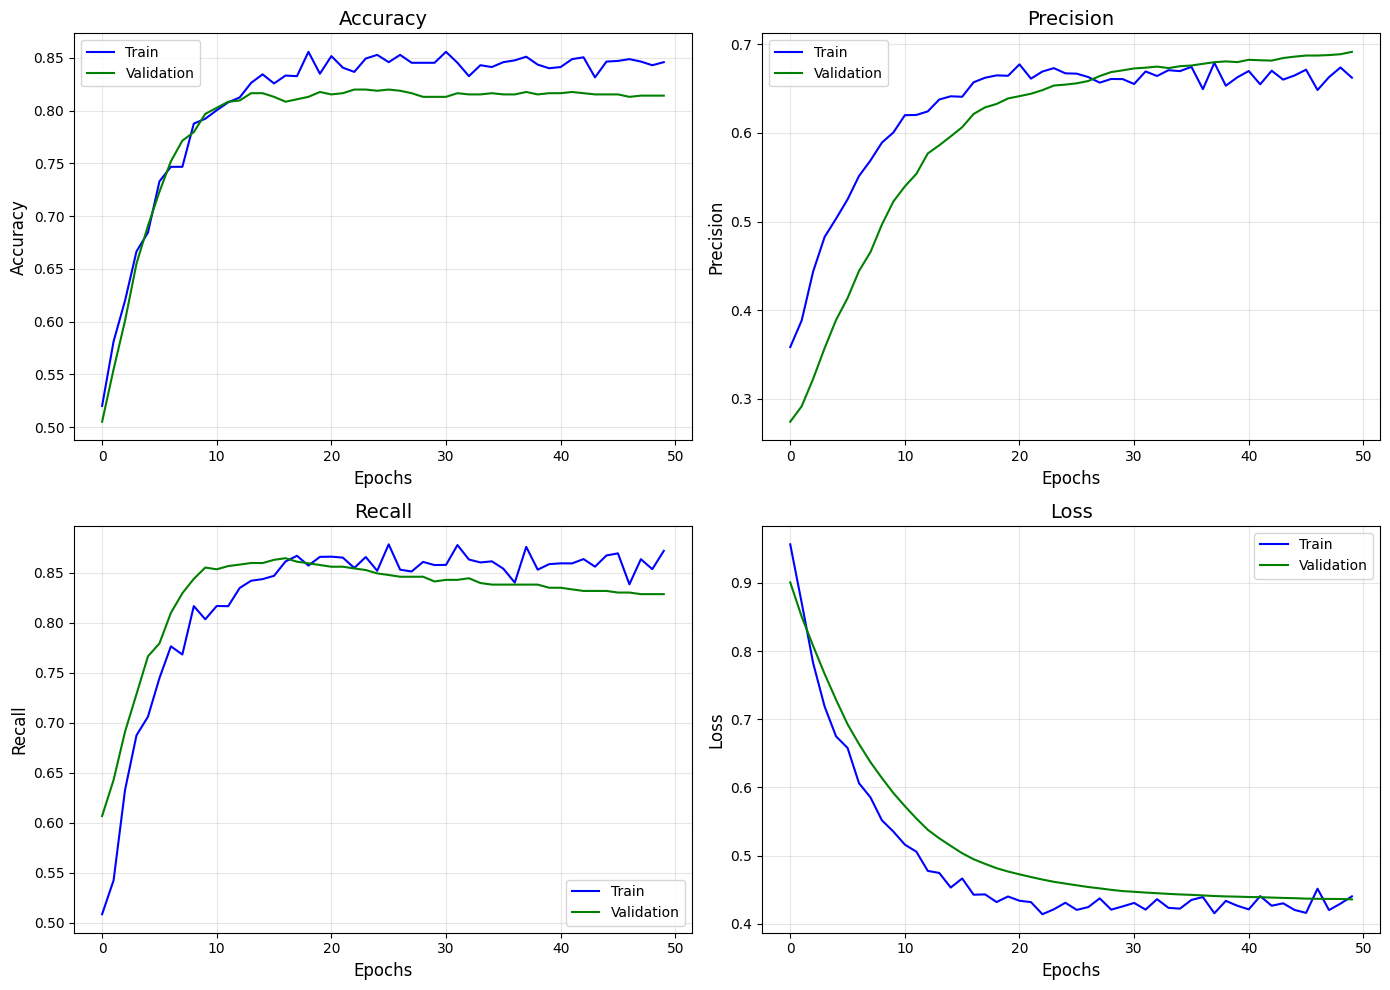

In [129]:
def plot_summary_avg(avg_metrics):
    plt.figure(figsize=(14, 10))

    # Graficar Accuracy
    plt.subplot(2, 2, 1)
    plt.title('Accuracy', fontsize=14)
    plt.plot(avg_metrics['accuracy'], color='blue', label='Train')
    plt.plot(avg_metrics['val_accuracy'], color='green', label='Validation')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Graficar Precision
    plt.subplot(2, 2, 2)
    plt.title('Precision', fontsize=14)
    plt.plot(avg_metrics['precision'], color='blue', label='Train')
    plt.plot(avg_metrics['val_precision'], color='green', label='Validation')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Graficar Recall
    plt.subplot(2, 2, 3)
    plt.title('Recall', fontsize=14)
    plt.plot(avg_metrics['recall'], color='blue', label='Train')
    plt.plot(avg_metrics['val_recall'], color='green', label='Validation')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Recall', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Graficar Loss
    plt.subplot(2, 2, 4)
    plt.title('Loss', fontsize=14)
    plt.plot(avg_metrics['loss'], color='blue', label='Train')
    plt.plot(avg_metrics['val_loss'], color='green', label='Validation')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
    
plot_summary_avg(avg_metrics)

## Evaluate the kfold models

In [ ]:
from tensorflow import keras

num_folds = 3
test_results = []

for i in range(num_folds):
    print(f"Evaluate model fold {i + 1}...")

    model = keras.models.load_model(f'models/multilabels_model_fold{i + 1}.keras')

    # Evaluate test
    result = model.evaluate(img_test, verbose=1)
    test_results.append(result)

# Metrics
avg_test_results = np.mean(test_results, axis=0)
print("\Average de metrics on test:")
print(f"Loss:      {avg_test_results[0]:.4f}")
print(f"Accuracy:  {avg_test_results[1]:.4f}")
print(f"Precision: {avg_test_results[2]:.4f}")
print(f"Recall:    {avg_test_results[3]:.4f}")


Evaluate model fold 1...
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step - accuracy: 0.8723 - loss: 0.3937 - precision: 0.7141 - recall: 0.8840
Evaluate model fold 2...
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step - accuracy: 0.8679 - loss: 0.4126 - precision: 0.6954 - recall: 0.8960
Evaluate model fold 3...
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 645ms/step - accuracy: 0.8816 - loss: 0.4231 - precision: 0.7383 - recall: 0.8924
\Average de metrics on test:
Loss:      0.4230
Accuracy:  0.8677
Precision: 0.6997
Recall:    0.8725
